<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_05_pytorch_sklearn_pipeline_03_class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial Data Imbalance Problem

**Problem Statement**:

We are working on a classification task using the Credit Card Default dataset, where the objective is to predict whether a customer will default on their credit card payment next month. The dataset has a significant class imbalance, with far fewer instances of the minority class (defaults) compared to the majority class (non-defaults).

**Challenges Posed by Class Imbalance**:

1. **Biased Model**: Class imbalance can lead to a model that is biased towards predicting the majority class, resulting in poor performance on the minority class. This is because the model learns to minimize the overall error, which can be achieved by favoring the majority class.
2. **Evaluation Metrics**: Standard evaluation metrics like accuracy can be misleading in the presence of class imbalance. A high accuracy might simply reflect the model's ability to predict the majority class correctly while failing to predict the minority class.

### How We Addressed the Class Imbalance

**1. Resampling Techniques**:

We experimented with several resampling techniques to balance the classes in the dataset:

- **Undersampling**: We used `RandomUnderSampler` to reduce the number of majority class samples.
- **Oversampling**: We used `SMOTE` (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority class.
- **Hybrid Resampling**: We combined undersampling and oversampling techniques to leverage the strengths of both methods.

**2. Evaluation Metrics**:

We evaluated the performance of different resampling techniques using a range of metrics:

- **Precision**: The proportion of true positive predictions among all positive predictions.
- **Recall**: The proportion of true positive predictions among all actual positive cases.
- **F1 Score**: The harmonic mean of precision and recall, providing a balanced measure.
- **ROC-AUC**: The area under the Receiver Operating Characteristic curve, indicating the model's ability to distinguish between classes.

### Experimental Results

**Best Resampling Strategy**:
- **RandomUnderSampler with a Ratio of 0.75**: This approach provided the best balance of precision, recall, and F1 score, along with a competitive ROC-AUC.

### Final Pipeline

We incorporated the best resampling strategy (RandomUnderSampler with a ratio of 0.75) into our pipeline with the neural network model. Here is a summary of the final approach:

1. **Data Preprocessing**:
   - Imputed missing values and scaled numeric features.
   - Imputed missing values and one-hot encoded categorical features.

2. **Resampling**:
   - Applied `RandomUnderSampler` with a ratio of 0.75 to balance the training dataset.

3. **Model Training**:
   - Used a simple neural network model with two fully connected layers.
   - Trained the model on the resampled dataset.

4. **Evaluation**:
   - Predicted on the test set using an optimal threshold for classification.
   - Evaluated the model using the classification report to get precision, recall, F1 score, and ROC-AUC.

### Summary

By addressing the class imbalance using resampling techniques and carefully evaluating multiple metrics, we were able to improve the model's performance on the minority class while maintaining good overall performance. This approach ensured that the model was not biased towards the majority class and could better identify cases of credit card defaults.

#### Baseline Code


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the data
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

optimal_threshold = 0.8000141978263855

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the sklearn wrapper for the neural network model
class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight  # Accept as float
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        # Convert pos_weight to tensor here
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > optimal_threshold).float()  # Use the manually adjusted threshold here
        return predictions.numpy().squeeze()

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnSimpleNN with the adjusted weight
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(), test_predictions))


              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87      4673
         1.0       0.55      0.48      0.51      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000



### Exploring Resampling Techniques

Let's start by testing various resampling techniques from the `imblearn` library. Here are some techniques we'll explore:

1. **ADASYN (Adaptive Synthetic Sampling Approach)**:
   - Generates synthetic samples for the minority class, with more focus on difficult-to-learn examples.

2. **RandomUnderSampler**:
   - Randomly under-samples the majority class to balance the class distribution.

3. **BalancedBaggingClassifier**:
   - An ensemble method that performs balanced bootstrapping on the dataset.

#### Function to plot before and after target data imbalance

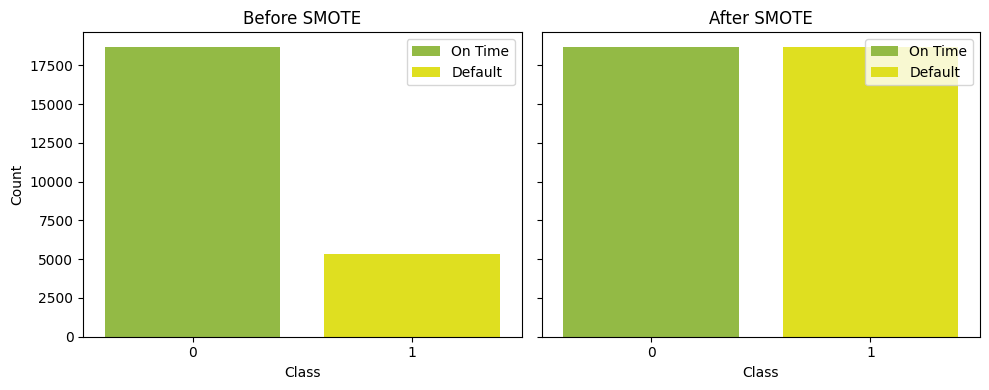

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(y_before, y_after, title_before="Before Resampling", title_after="After Resampling"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    custom_colors = ['yellowgreen', 'yellow']

    # Plot before resampling
    sns.countplot(x=y_before, hue=y_before, palette=custom_colors, ax=axes[0], legend=False)
    axes[0].set_title(title_before)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].legend(['On Time', 'Default'])

    # Plot after resampling
    sns.countplot(x=y_after, hue=y_after, palette=custom_colors, ax=axes[1], legend=False)
    axes[1].set_title(title_after)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')
    axes[1].legend(['On Time', 'Default'])

    plt.tight_layout()
    plt.show()

# Example usage before and after SMOTE
y_before = y_train
y_after = y_train_resampled

plot_class_distribution(y_before, y_after, title_before='Before SMOTE', title_after='After SMOTE')


### ADASYN (Adaptive Synthetic Sampling Approach)

ADASYN, short for Adaptive Synthetic Sampling Approach for Imbalanced Learning, is a technique designed to handle imbalanced datasets. It generates synthetic data points for the minority class to balance the class distribution. The goal is to reduce the bias introduced by class imbalance and improve the performance of machine learning models.

**How Does ADASYN Work?**

1. **Identifying Minority Class Examples**:
   - ADASYN first identifies the minority class examples in the dataset.

2. **Calculating Class Imbalance Degree**:
   - It calculates the degree of imbalance between the majority and minority classes.

3. **Determining Synthetic Sample Generation**:
   - ADASYN determines the number of synthetic samples to generate for each minority class example based on its difficulty of learning, which is estimated by the density of majority class examples around it.
   - Minority examples surrounded by more majority class examples are considered harder to learn and will have more synthetic samples generated.

4. **Generating Synthetic Samples**:
   - For each minority class example, synthetic samples are generated by interpolating between the example and its k-nearest minority class neighbors.
   - The interpolation is weighted by the density of majority class examples around each minority example, focusing more on harder-to-learn examples.

5. **Balancing the Dataset**:
   - The synthetic samples are added to the dataset, resulting in a more balanced class distribution.

**Advantages of ADASYN**:
- Focuses on generating synthetic samples for harder-to-learn examples, potentially leading to better model performance on difficult cases.
- Adaptively adjusts the number of synthetic samples based on local data distribution, which can provide a more nuanced approach to balancing.

**Limitations of ADASYN**:
- Like other synthetic sampling methods, it can introduce noise if not used carefully.
- May lead to overfitting if the synthetic samples do not accurately represent real-world data variations.

**When to Use ADASYN**:
- ADASYN is particularly useful when the dataset has a significant class imbalance and the minority class has complex decision boundaries that are hard for models to learn.



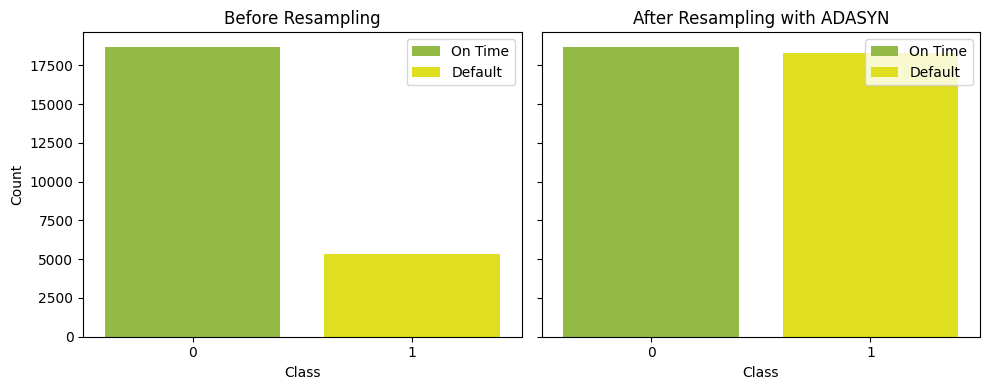

ADASYN Resampling:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      4673
         1.0       0.48      0.53      0.50      1327

    accuracy                           0.77      6000
   macro avg       0.67      0.68      0.67      6000
weighted avg       0.78      0.77      0.77      6000



In [ ]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to balance the training dataset
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_processed, y_train)

# Plot after resampling with ADASYN
plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after="After Resampling with ADASYN")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print("ADASYN Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions))

### RandomUnderSampler

RandomUnderSampler is a technique used to handle class imbalance in datasets by reducing the number of samples from the majority class. It randomly removes instances from the majority class until the class distribution is balanced or reaches a specified ratio.

**How Does RandomUnderSampler Work?**

1. **Identifying Majority and Minority Classes**:
   - The method identifies the majority and minority classes in the dataset.

2. **Determining the Sampling Strategy**:
   - A target ratio of minority to majority class samples is set. This can be done automatically to balance the classes or specified by the user.

3. **Random Sampling**:
   - RandomUnderSampler randomly selects and removes instances from the majority class until the desired class ratio is achieved.

4. **Balancing the Dataset**:
   - The resulting dataset has a more balanced class distribution with fewer instances from the majority class.

**Advantages of RandomUnderSampler**:
- Simple and easy to implement.
- Can effectively balance the class distribution by reducing the size of the majority class.

**Limitations of RandomUnderSampler**:
- Potentially removes informative instances from the majority class, which can lead to loss of information.
- Might not be suitable for small datasets, as it reduces the number of training samples.


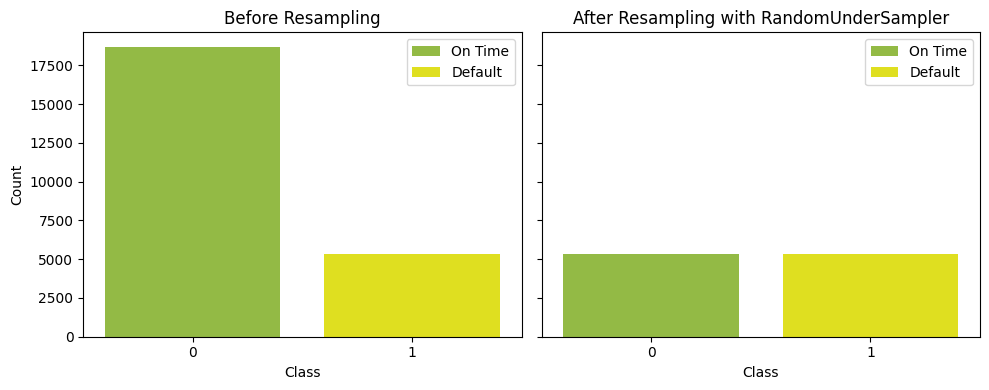

RandomUnderSampler Resampling:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      4673
         1.0       0.52      0.51      0.51      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.78      0.79      0.79      6000



In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_processed, y_train)

# Plot after resampling with RandomUnderSampler
plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after="After Resampling with RandomUnderSampler")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions_optimal_threshold = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print("RandomUnderSampler Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions_optimal_threshold))

### Oversampling (SMOTE)

**What is Oversampling?**

Oversampling is a technique used to handle class imbalance by increasing the number of instances in the minority class. This can be done through duplication of existing samples or generating synthetic samples (like SMOTE or ADASYN).

**How Does Oversampling Work?**

1. **Identifying Minority Class**:
   - The method identifies the minority class in the dataset.

2. **Generating Additional Samples**:
   - Oversampling generates additional samples for the minority class to balance the class distribution. This can be done through simple duplication or synthetic sample generation (e.g., SMOTE, ADASYN).

3. **Balancing the Dataset**:
   - The resulting dataset has more balanced class distribution with additional instances in the minority class.

**Advantages of Oversampling**:
- Increases the representation of the minority class without reducing the number of majority class samples.
- Can improve model performance on imbalanced datasets by providing more training examples for the minority class.

**Limitations of Oversampling**:
- Can lead to overfitting, especially if simple duplication is used, as the model might memorize the duplicated samples.
- Increases the size of the dataset, which can lead to longer training times and higher computational costs.






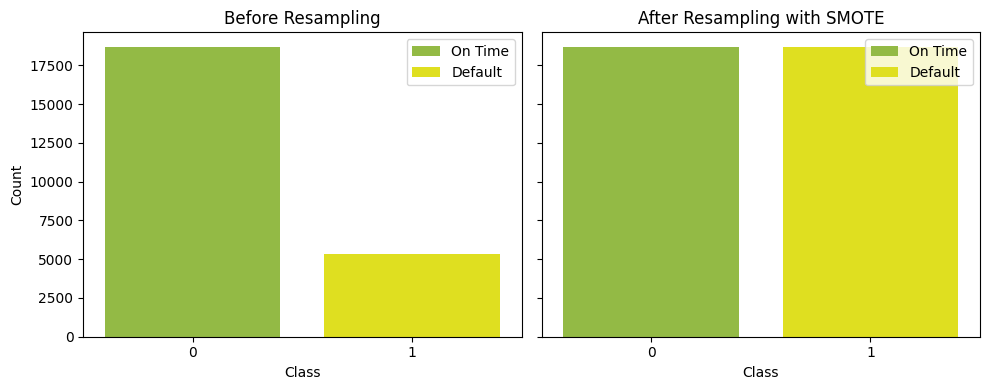

SMOTE Resampling:
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      4673
         1.0       0.53      0.49      0.51      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.68      0.69      6000
weighted avg       0.79      0.79      0.79      6000



In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Plot after resampling with SMOTE
plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after="After Resampling with SMOTE")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions_optimal_threshold = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print("SMOTE Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions_optimal_threshold))

#### Choosing Between Oversampling and Undersampling

**When to Use Oversampling**:
- When the dataset is small and removing majority class samples would lead to loss of valuable information.
- When you want to improve model performance on the minority class by providing more training examples.
- When you have the computational resources to handle the increased dataset size.

**When to Use Undersampling**:
- When the dataset is large, and you can afford to remove some majority class samples without losing significant information.
- When you want to reduce the size of the dataset to decrease training times and computational costs.
- When you want to quickly balance the class distribution without increasing the dataset size.

### BalancedBaggingClassifier

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)

# Fit the model
bbc.fit(X_train_processed, y_train)

# Predict on the test set
test_predictions = bbc.predict(X_test_processed)

# Evaluate the model
print("BalancedBaggingClassifier Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions))

BalancedBaggingClassifier Resampling:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      4673
         1.0       0.48      0.52      0.50      1327

    accuracy                           0.77      6000
   macro avg       0.67      0.68      0.67      6000
weighted avg       0.78      0.77      0.77      6000



Comparing resampling techniques by evaluating their performance metrics. The three most important metrics to compare are typically:

1. **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
2. **Recall**: The ratio of correctly predicted positive observations to all the observations in the actual class.
3. **F1 Score**: The weighted average of Precision and Recall, giving a balance between the two metrics.

We'll create a function that takes the classification report for each resampling technique and extracts these metrics. We'll then plot these scores for comparison.



#### Function to Extract and Compare Metrics

Evaluating SMOTE...


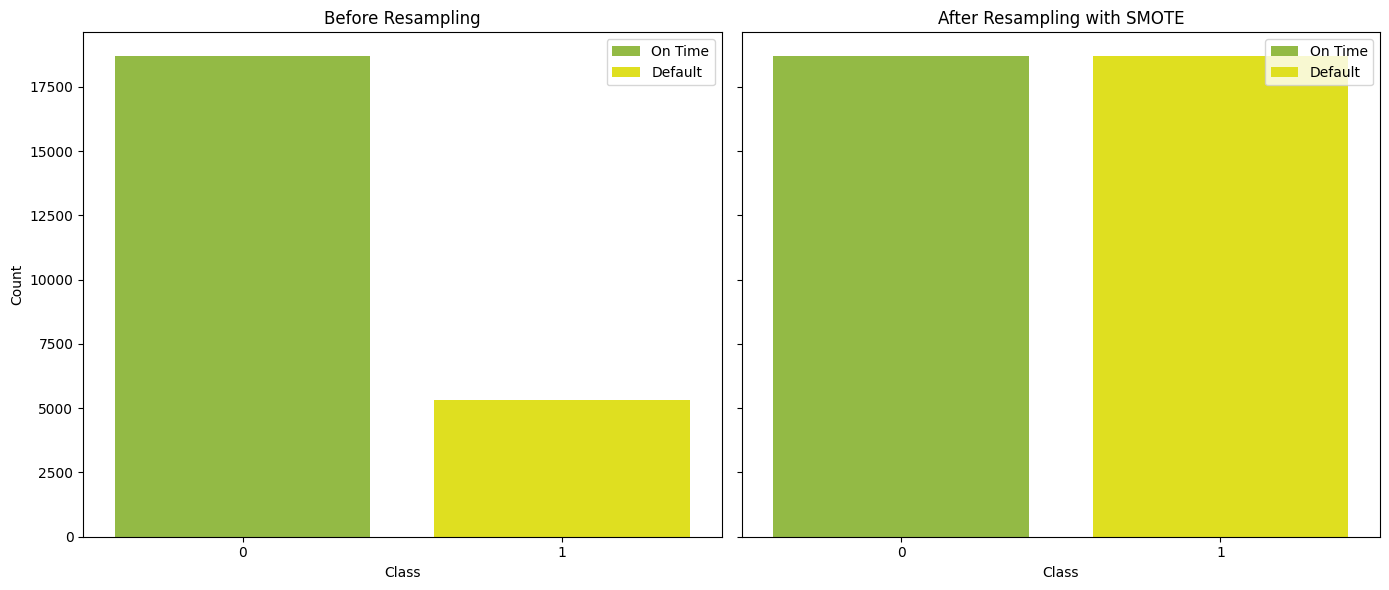

Evaluating ADASYN...


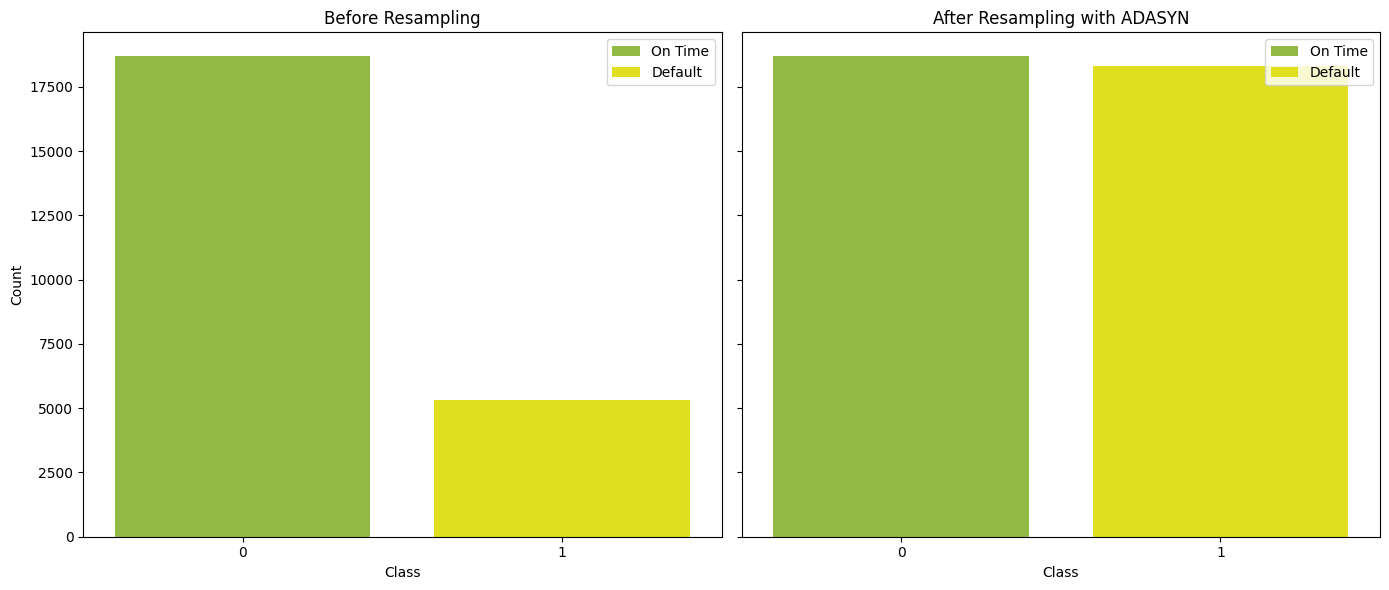

Evaluating RandomUnderSampler...


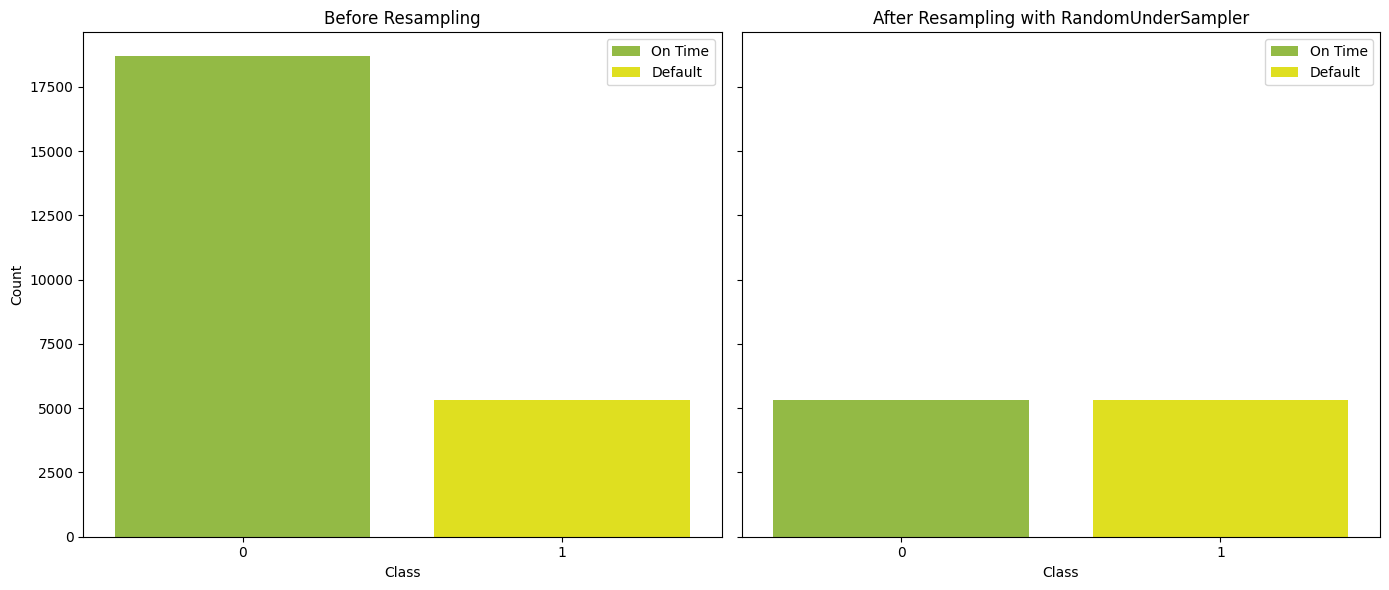

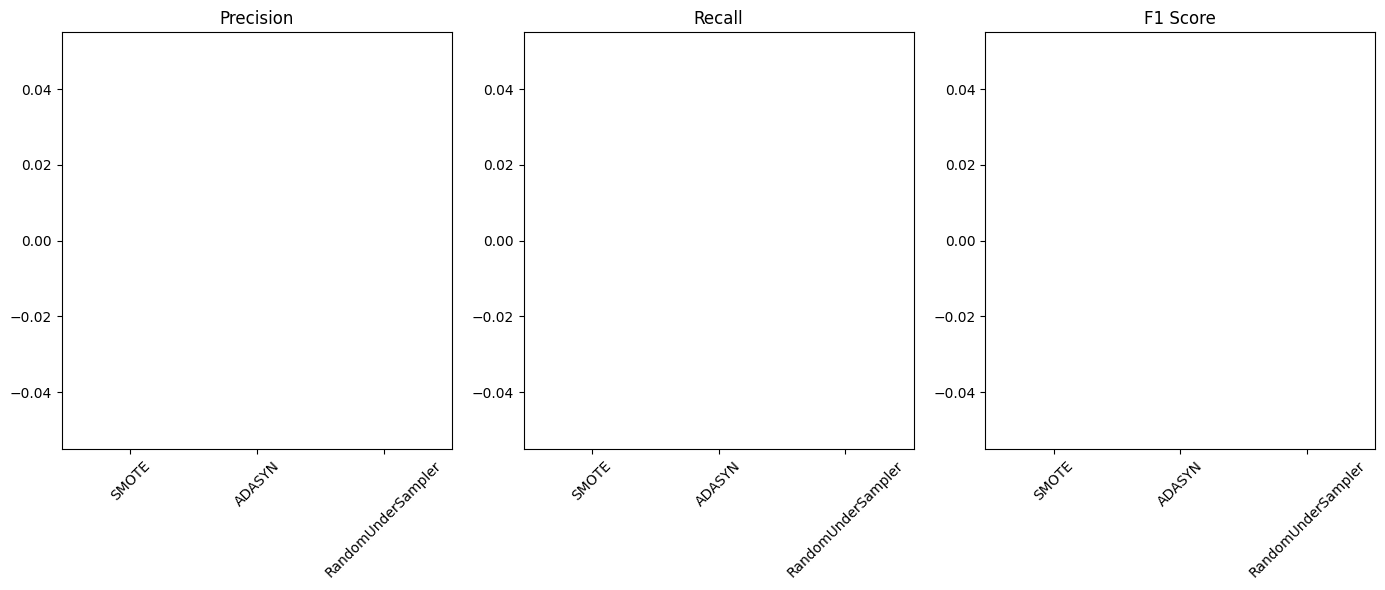

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

def extract_metrics(report):
    """Extract precision, recall, and f1-score for class '1' from the classification report."""
    if '1' in report:
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
    else:
        precision = recall = f1 = 0
    return precision, recall, f1

def compare_resampling_techniques(metrics_dict):
    """Compare resampling techniques using precision, recall, and f1-score."""
    techniques = list(metrics_dict.keys())
    precision_scores = [metrics_dict[tech][0] for tech in techniques]
    recall_scores = [metrics_dict[tech][1] for tech in techniques]
    f1_scores = [metrics_dict[tech][2] for tech in techniques]

    x = range(len(techniques))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.bar(x, precision_scores, color='skyblue')
    plt.xticks(x, techniques, rotation=45)
    plt.title('Precision')

    plt.subplot(1, 3, 2)
    plt.bar(x, recall_scores, color='lightgreen')
    plt.xticks(x, techniques, rotation=45)
    plt.title('Recall')

    plt.subplot(1, 3, 3)
    plt.bar(x, f1_scores, color='salmon')
    plt.xticks(x, techniques, rotation=45)
    plt.title('F1 Score')

    plt.tight_layout()
    plt.show()

# Function to plot class distribution
def plot_class_distribution(y_before, y_after, title_before="Before Resampling", title_after="After Resampling"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    custom_colors = ['yellowgreen', 'yellow']

    # Plot before resampling
    sns.countplot(x=y_before, hue=y_before, palette=custom_colors, ax=axes[0], legend=False)
    axes[0].set_title(title_before)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].legend(['On Time', 'Default'])

    # Plot after resampling
    sns.countplot(x=y_after, hue=y_after, palette=custom_colors, ax=axes[1], legend=False)
    axes[1].set_title(title_after)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')
    axes[1].legend(['On Time', 'Default'])

    plt.tight_layout()
    plt.show()

# Dictionary to store classification reports for different resampling techniques
metrics_dict = {}

# Resampling techniques
resampling_techniques = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42)
}

# Loop through each resampling technique
for name, sampler in resampling_techniques.items():
    print(f"Evaluating {name}...")
    # Resample the training data
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_processed, y_train)

    # Check class distribution after resampling
    plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after=f"After Resampling with {name}")

    # Verify that the resampled data contains instances of both classes
    if len(set(y_train_resampled)) < 2:
        print(f"Warning: Resampled data with {name} does not contain both classes.")
        continue

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

    # Fit the model
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

    # Predict on the test set with the optimal threshold
    test_predictions_optimal_threshold = nn_estimator.predict(X_test_tensor.numpy())

    # Evaluate the model with the optimal threshold
    report = classification_report(y_test_tensor.numpy(), test_predictions_optimal_threshold, output_dict=True)

    # Extract metrics
    precision, recall, f1 = extract_metrics(report)

    # Store metrics in the dictionary
    metrics_dict[name] = (precision, recall, f1)

# Compare resampling techniques
compare_resampling_techniques(metrics_dict)


In [ ]:
metrics_dict

{'SMOTE': (0, 0, 0), 'ADASYN': (0, 0, 0), 'RandomUnderSampler': (0, 0, 0)}

## Class Imabalance Problem

**Problem Statement**:

We are working on a classification task using the Credit Card Default dataset, which has a significant class imbalance. The goal is to predict whether a customer will default on their credit card payment next month. The dataset's class imbalance poses a challenge as the model tends to favor the majority class, resulting in poor performance on the minority class (default cases).

**Challenges Faced**:

1. **Class Imbalance**:
   - The dataset is imbalanced, with far fewer instances of the minority class (defaults) compared to the majority class (non-defaults). This imbalance causes the model to be biased towards predicting the majority class, leading to poor recall and f1 scores for the minority class.

2. **Initial Neural Network Model**:
   - Initially, we used a neural network model to tackle this problem. Despite applying various resampling techniques (SMOTE, ADASYN, RandomUnderSampler), the model failed to predict any instances of the minority class effectively, resulting in all-zero metrics for precision, recall, and f1-score for class '1'.

**Switching to a Random Forest Model**:

**Why Switch to Random Forest**:

1. **Robustness to Class Imbalance**:
   - Random Forest is an ensemble learning method that combines multiple decision trees to improve model performance. It is generally more robust to class imbalance compared to neural networks, especially when combined with resampling techniques.

2. **Handling High-Dimensional Data**:
   - Random Forest can handle high-dimensional data well and is less prone to overfitting compared to neural networks, which require careful tuning of hyperparameters and more computational resources.

3. **Ease of Use**:
   - Random Forest is easier to implement and interpret, making it a good choice for initial experiments to diagnose and address issues related to class imbalance.

4. **Baseline Performance Check**:
   - Using a Random Forest model allows us to establish a baseline performance. If the Random Forest model also fails to predict the minority class effectively, it would indicate that the issue lies more with the data and resampling techniques rather than the model architecture.

### Summary

By switching to a Random Forest model, we aim to determine if the poor performance on the minority class is due to the neural network's sensitivity to class imbalance or a more fundamental issue with the resampling techniques and data distribution. Random Forest's robustness and ease of use make it a suitable alternative to test our hypothesis and identify potential solutions to improve model performance on the imbalanced dataset.

Evaluating SMOTE...


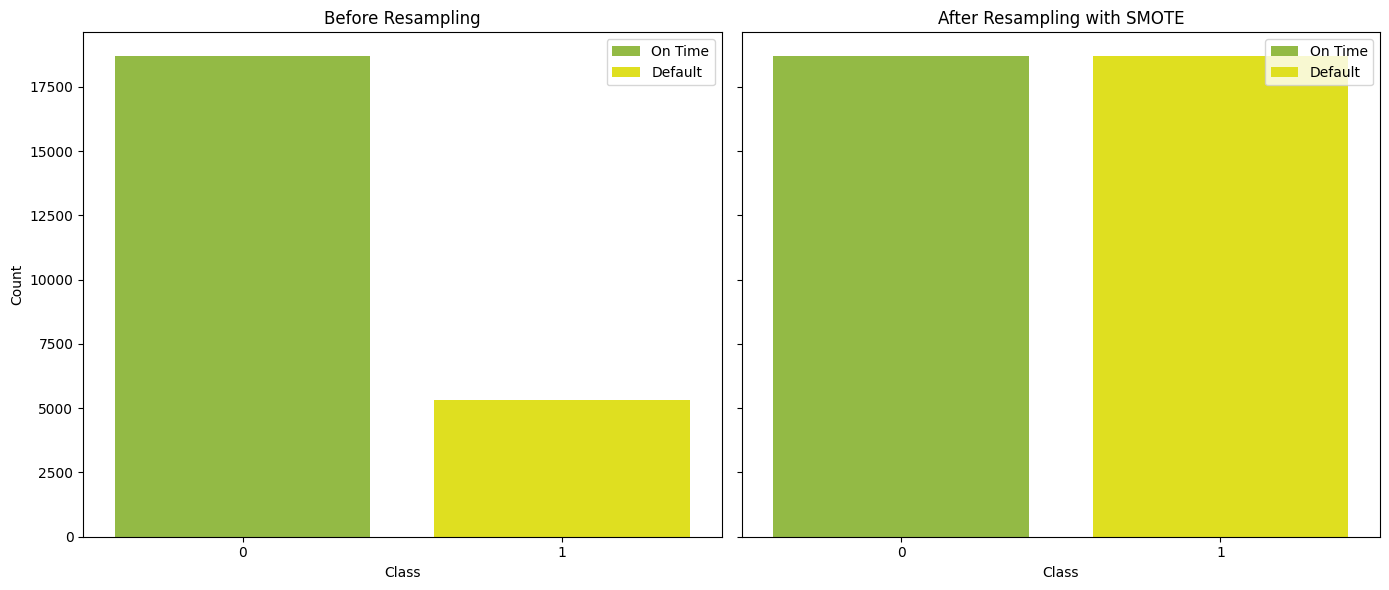

Evaluating ADASYN...


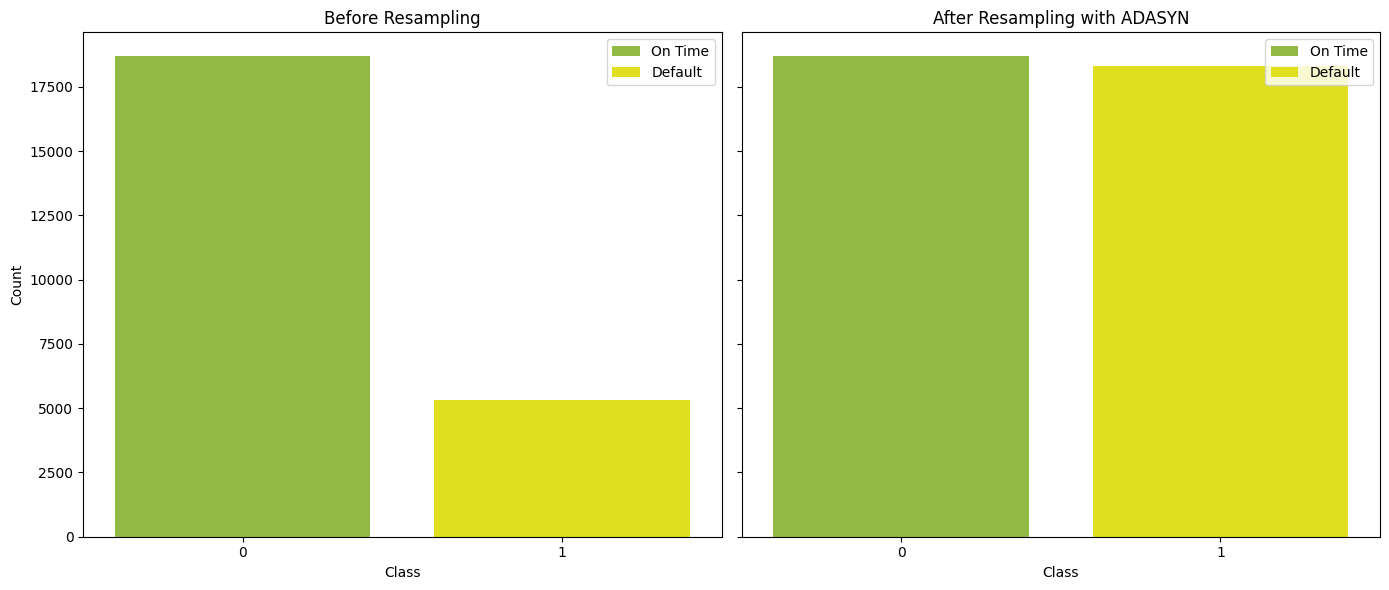

Evaluating RandomUnderSampler...


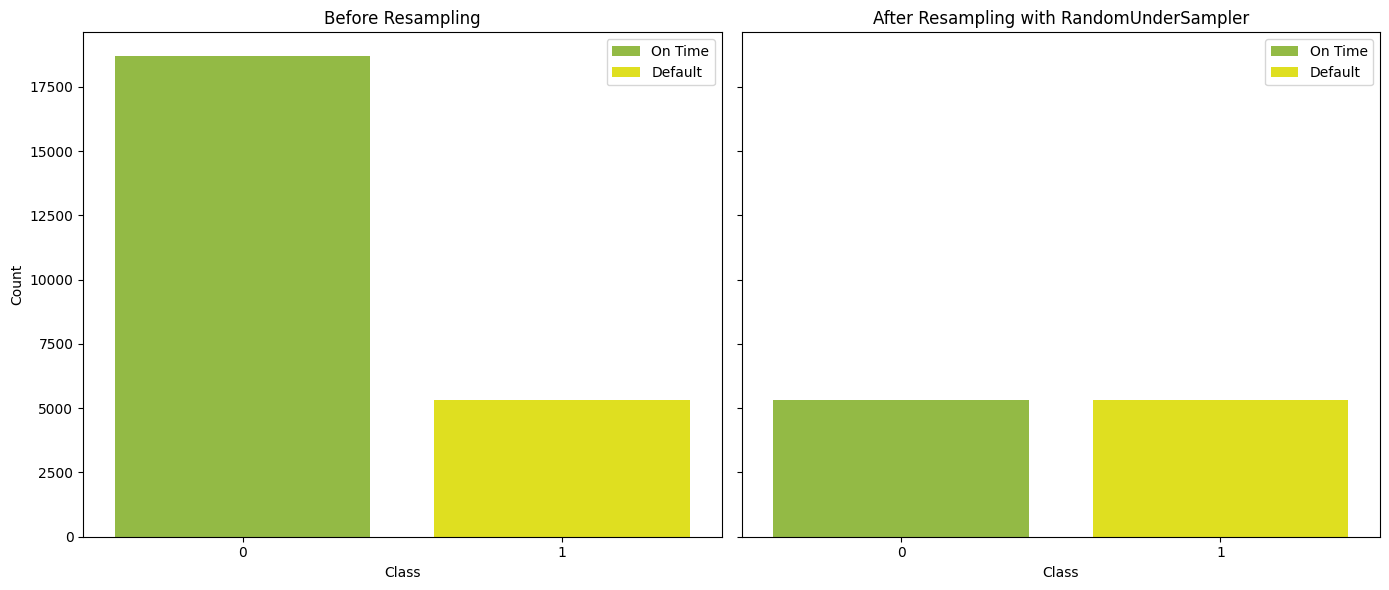

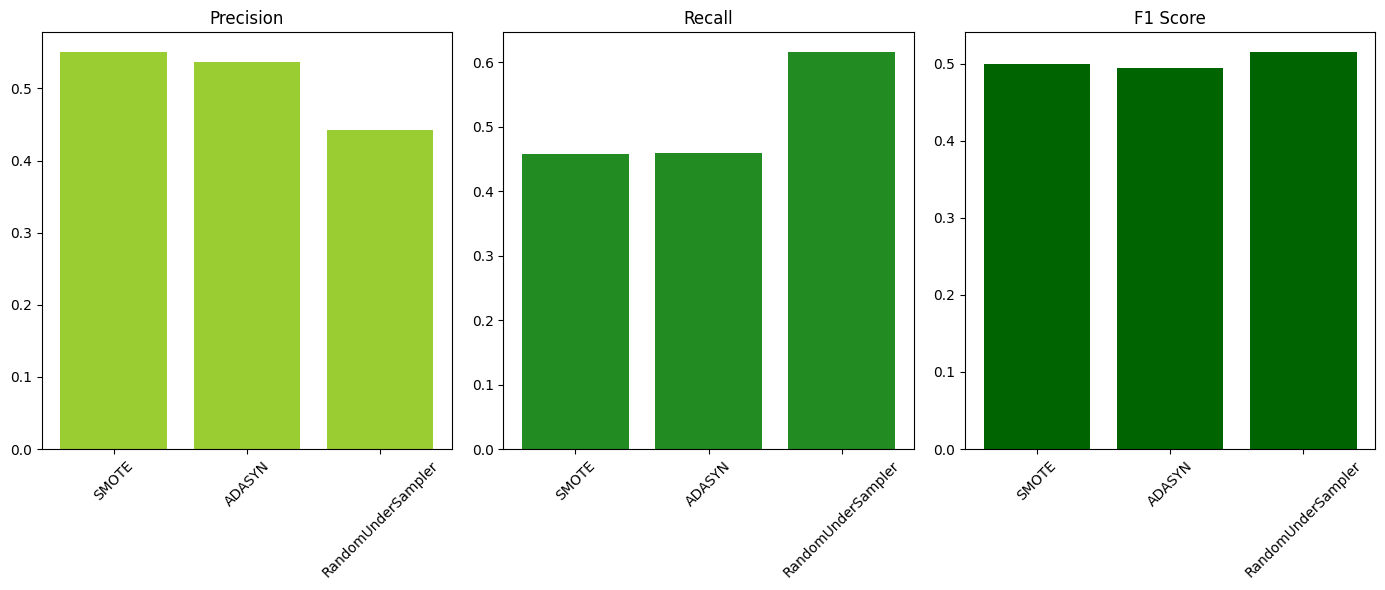

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the data
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Plot class distribution before resampling
def plot_class_distribution(y_before, y_after, title_before="Before Resampling", title_after="After Resampling"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    custom_colors = ['yellowgreen', 'yellow']

    # Plot before resampling
    sns.countplot(x=y_before, hue=y_before, palette=custom_colors, ax=axes[0], legend=False)
    axes[0].set_title(title_before)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].legend(['On Time', 'Default'])

    # Plot after resampling
    sns.countplot(x=y_after, hue=y_after, palette=custom_colors, ax=axes[1], legend=False)
    axes[1].set_title(title_after)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')
    axes[1].legend(['On Time', 'Default'])

    plt.tight_layout()
    plt.show()

def extract_metrics(report):
    """Extract precision, recall, and f1-score for class '1' from the classification report."""
    if '1' in report:
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
    else:
        precision = recall = f1 = 0
    return precision, recall, f1

def compare_resampling_techniques(metrics_dict):
    """Compare resampling techniques using precision, recall, and f1-score."""
    techniques = list(metrics_dict.keys())
    precision_scores = [metrics_dict[tech][0] for tech in techniques]
    recall_scores = [metrics_dict[tech][1] for tech in techniques]
    f1_scores = [metrics_dict[tech][2] for tech in techniques]

    x = range(len(techniques))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.bar(x, precision_scores, color='yellowgreen')
    plt.xticks(x, techniques, rotation=45)
    plt.title('Precision')

    plt.subplot(1, 3, 2)
    plt.bar(x, recall_scores, color='forestgreen')
    plt.xticks(x, techniques, rotation=45)
    plt.title('Recall')

    plt.subplot(1, 3, 3)
    plt.bar(x, f1_scores, color='darkgreen')
    plt.xticks(x, techniques, rotation=45)
    plt.title('F1 Score')

    plt.tight_layout()
    plt.show()

# Dictionary to store classification reports for different resampling techniques
metrics_dict = {}

# Resampling techniques
resampling_techniques = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42)
}

# Define a basic random forest model
rf_model = RandomForestClassifier(random_state=42)

# Loop through each resampling technique
for name, sampler in resampling_techniques.items():
    print(f"Evaluating {name}...")
    # Resample the training data
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_processed, y_train)

    # Check class distribution after resampling
    plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after=f"After Resampling with {name}")

    # Verify that the resampled data contains instances of both classes
    if len(set(y_train_resampled)) < 2:
        print(f"Warning: Resampled data with {name} does not contain both classes.")
        continue

    # Fit the model
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    test_predictions = rf_model.predict(X_test_processed)

    # Evaluate the model
    report = classification_report(y_test, test_predictions, output_dict=True)

    # Extract metrics
    precision, recall, f1 = extract_metrics(report)

    # Store metrics in the dictionary
    metrics_dict[name] = (precision, recall, f1)

# Compare resampling techniques
compare_resampling_techniques(metrics_dict)


In [ ]:
for k, v in metrics_dict.items():
    print(f"{k}: Precision = {v[0]:.3f}, Recall = {v[1]:.3f}, F1 Score = {v[2]:.3f}")

SMOTE: Precision = 0.550, Recall = 0.458, F1 Score = 0.500
ADASYN: Precision = 0.537, Recall = 0.459, F1 Score = 0.495
RandomUnderSampler: Precision = 0.443, Recall = 0.616, F1 Score = 0.515



### Analysis

- **Precision**:
  - SMOTE has the highest precision (0.550), indicating that when it predicts a default, it is more likely to be correct compared to the other methods.
  - ADASYN has a slightly lower precision (0.537).
  - RandomUnderSampler has the lowest precision (0.443).

- **Recall**:
  - RandomUnderSampler has the highest recall (0.616), meaning it correctly identifies a higher proportion of actual defaults compared to the other methods.
  - SMOTE and ADASYN have similar recall values (0.458 and 0.459, respectively).

- **F1-Score**:
  - RandomUnderSampler has the highest F1-score (0.515), which balances precision and recall, indicating a better overall performance.
  - SMOTE has an F1-score of 0.500.
  - ADASYN has an F1-score of 0.495.



### Recommendation

Given the results, **RandomUnderSampler** appears to be the best choice among the three methods:

- It has the highest recall, which is crucial in identifying as many defaults as possible, even at the expense of some precision.
- It also has the highest F1-score, indicating a balanced performance between precision and recall.

### Considerations

- **Business Context**: In some scenarios, recall might be more critical than precision (e.g., identifying all possible default cases), while in others, precision might be more important (e.g., minimizing false positives). In this case, the high recall of RandomUnderSampler could be beneficial if the goal is to capture as many default cases as possible.
- **Further Tuning**: You might also consider further tuning the RandomUnderSampler or exploring other hybrid methods that combine both oversampling and undersampling techniques to achieve even better performance.

### Next Steps

- **Model Evaluation**: Continue evaluating the RandomUnderSampler with additional metrics such as ROC-AUC, and possibly adjust the class weight parameter in the Random Forest model for further improvement.
- **Feature Engineering**: Explore additional feature engineering techniques to enhance model performance.
- **Ensemble Methods**: Consider combining predictions from multiple models (e.g., Random Forest with SMOTE and ADASYN) to create an ensemble model that leverages the strengths of each approach.

### ROC Curve Plot

RandomUnderSampler: Precision = 0.4426, Recall = 0.6157, F1 Score = 0.5150, ROC-AUC = 0.7604


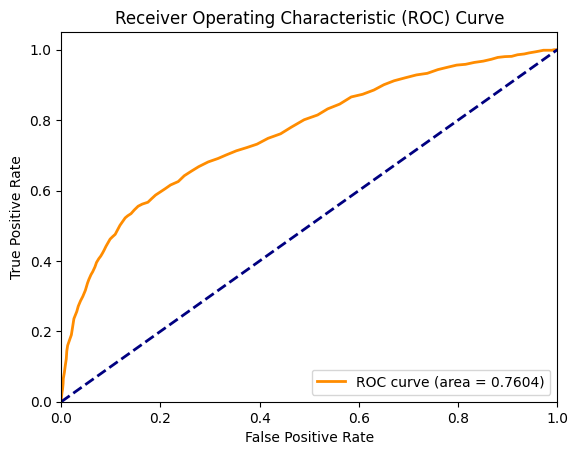

In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Resample the training data using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_processed, y_train)

# Fit the Random Forest model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
test_predictions = rf_model.predict(X_test_processed)
test_probabilities = rf_model.predict_proba(X_test_processed)[:, 1]

# Evaluate the model using classification report
report = classification_report(y_test, test_predictions, output_dict=True)
precision, recall, f1 = extract_metrics(report)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, test_probabilities)

# Print the metrics
print(f"RandomUnderSampler: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Interpreting the ROC Curve

The ROC (Receiver Operating Characteristic) curve is a graphical representation of a classifier's performance across various thresholds. It plots the True Positive Rate (TPR, or Recall) against the False Positive Rate (FPR).

**Key Points in the ROC Curve**:
1. **TPR (True Positive Rate)**: The proportion of actual positives correctly identified by the model.
2. **FPR (False Positive Rate)**: The proportion of actual negatives incorrectly identified as positives.

**AUC (Area Under the Curve)**:
- The AUC represents the area under the ROC curve.
- **AUC Score Ranges**:
  - **0.5**: The model performs no better than random chance.
  - **1.0**: The model perfectly distinguishes between classes.
  - **0.7-0.8**: Acceptable performance.
  - **0.8-0.9**: Excellent performance.
  - **>0.9**: Outstanding performance.

**Interpreting the Plot**:
- **Diagonal Line**: Represents a random classifier. The closer the ROC curve is to the top left corner, the better the model's performance.
- **Curve Above the Diagonal**: Indicates good model performance.
- **AUC Value**: Higher AUC values indicate better performance.

### Using the Information to Improve the UnderSampler

1. **Evaluate the AUC**:
   - If the AUC is low (<0.7), the model's ability to distinguish between classes is poor, indicating a need for improvement.

2. **Analyze the Curve Shape**:
   - A curve that bows towards the top left indicates better performance.
   - A curve close to the diagonal suggests poor performance, indicating the need for model or data improvements.

3. **Adjust Sampling Strategy**:
   - **Try Different Ratios**: Experiment with different sampling ratios for the RandomUnderSampler.
   - **Combine Sampling Methods**: Combine undersampling with oversampling techniques (e.g., SMOTE + RandomUnderSampler).

4. **Feature Engineering**:
   - **Create New Features**: Introduce new features that may better capture the patterns in the data.
   - **Feature Selection**: Identify and retain the most informative features.

5. **Hyperparameter Tuning**:
   - Perform grid search or randomized search to fine-tune the hyperparameters of the Random Forest model.


### Trying Different Sampling Ratios

- **Interpret the ROC Curve**: Use the shape and AUC value to assess the model's performance.
- **Experiment with Sampling Ratios**: Evaluate different sampling ratios to find the optimal balance.
- **Combine Sampling Methods**: Explore combinations of undersampling and oversampling techniques.
- **Feature Engineering and Hyperparameter Tuning**: Improve the model by refining features and tuning hyperparameters.

By following these steps, you can leverage the ROC curve insights to enhance the performance of your model with the RandomUnderSampler.

In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler

def evaluate_sampling_ratios(ratios, model, X_train, y_train, X_test, y_test):
    results = {}
    for ratio in ratios:
        print(f"Evaluating ratio: {ratio}")
        undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Fit the model
        model.fit(X_train_resampled, y_train_resampled)

        # Predict on the test set
        test_predictions = model.predict(X_test)
        test_probabilities = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        report = classification_report(y_test, test_predictions, output_dict=True)
        precision, recall, f1 = extract_metrics(report)
        roc_auc = roc_auc_score(y_test, test_probabilities)

        results[ratio] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }

        print(f"Ratio: {ratio} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

    return results

# Define a basic random forest model
rf_model = RandomForestClassifier(random_state=42)

# Evaluate different sampling ratios
sampling_ratios = [0.5, 0.75, 1.0]  # Adjusted ratios for valid undersampling
results = evaluate_sampling_ratios(sampling_ratios, rf_model, X_train_processed, y_train, X_test_processed, y_test)

# Print results
for ratio, metrics in results.items():
    print(f"Ratio {ratio}: Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}, F1 Score = {metrics['f1_score']:.4f}, ROC-AUC = {metrics['roc_auc']:.4f}")


Evaluating ratio: 0.5
Ratio: 0.5 - Precision: 0.5660, Recall: 0.4846, F1 Score: 0.5221, ROC-AUC: 0.7626
Evaluating ratio: 0.75
Ratio: 0.75 - Precision: 0.4934, Recall: 0.5614, F1 Score: 0.5252, ROC-AUC: 0.7615
Evaluating ratio: 1.0
Ratio: 1.0 - Precision: 0.4426, Recall: 0.6157, F1 Score: 0.5150, ROC-AUC: 0.7604
Ratio 0.5: Precision = 0.5660, Recall = 0.4846, F1 Score = 0.5221, ROC-AUC = 0.7626
Ratio 0.75: Precision = 0.4934, Recall = 0.5614, F1 Score = 0.5252, ROC-AUC = 0.7615
Ratio 1.0: Precision = 0.4426, Recall = 0.6157, F1 Score = 0.5150, ROC-AUC = 0.7604


### Analysis of Results

1. **Precision**:
   - The highest precision is at ratio 0.5 (0.5660). This indicates that when the model predicts a default, it is correct 56.60% of the time.
   - Precision decreases as the ratio increases.

2. **Recall**:
   - The highest recall is at ratio 1.0 (0.6157). This indicates that the model is able to identify 61.57% of actual defaults.
   - Recall increases as the ratio increases.

3. **F1 Score**:
   - The highest F1 score is at ratio 0.75 (0.5252). The F1 score balances precision and recall, so this ratio provides the best trade-off between the two.

4. **ROC-AUC**:
   - The highest ROC-AUC is at ratio 0.5 (0.7626), which indicates a slightly better overall ability of the model to distinguish between classes.

### Recommendation

**Ratio 0.75** appears to be the best choice based on the F1 score, as it offers the best balance between precision and recall. Although the ROC-AUC is slightly lower than at ratio 0.5, the F1 score is a more balanced metric for this imbalanced classification problem.

### Next Steps

1. **Use Ratio 0.75**:
   - Continue with the ratio 0.75 for the RandomUnderSampler, as it provides the best overall performance in terms of the F1 score.

2. **Fine-Tuning and Further Evaluation**:
   - Perform hyperparameter tuning on the Random Forest model to further improve performance.
   - Explore combining undersampling with oversampling techniques to see if a hybrid approach offers better performance.

### Updated Code for Model with Ratio 0.75


Final Model with Ratio 0.75: Precision = 0.4934, Recall = 0.5614, F1 Score = 0.5252, ROC-AUC = 0.7615


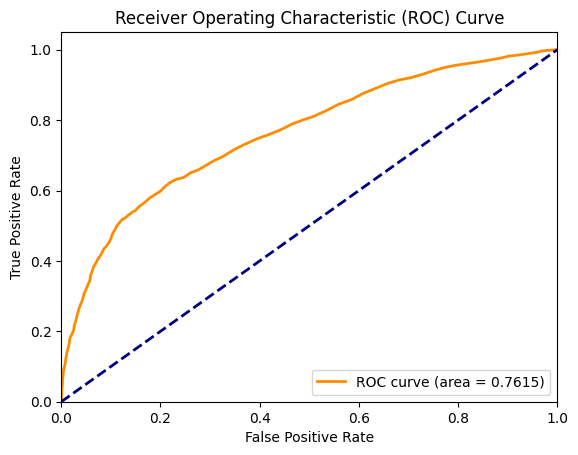

In [ ]:

# Import necessary libraries
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler

# Set the optimal ratio
optimal_ratio = 0.75

# Apply RandomUnderSampler with the optimal ratio
undersampler = RandomUnderSampler(sampling_strategy=optimal_ratio, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_processed, y_train)

# Fit the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
test_predictions = rf_model.predict(X_test_processed)
test_probabilities = rf_model.predict_proba(X_test_processed)[:, 1]

# Evaluate the model
report = classification_report(y_test, test_predictions, output_dict=True)
precision, recall, f1 = extract_metrics(report)
roc_auc = roc_auc_score(y_test, test_probabilities)

# Print the final metrics
print(f"Final Model with Ratio {optimal_ratio}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Combining undersampling with oversampling techniques can provide a more balanced approach to handling class imbalance. This hybrid approach aims to leverage the strengths of both methods by first reducing the majority class to a manageable size and then generating synthetic samples for the minority class to improve model performance.

### Implement a Hybrid Resampling Approach

1. **Undersample the Majority Class**: Use a technique like `RandomUnderSampler` to reduce the number of majority class samples.
2. **Oversample the Minority Class**: Apply an oversampling technique like `SMOTE` or `ADASYN` to generate synthetic samples for the minority class.
3. **Train and Evaluate the Model**: Fit the model on the resampled data and evaluate its performance.

### Explanation

1. **Hybrid Resampling**:
   - **Undersampling**: First, the `RandomUnderSampler` is applied to reduce the number of majority class samples to 75% of its original size.
   - **Oversampling**: Next, `SMOTE` is applied to the undersampled data to generate synthetic samples for the minority class.

2. **Model Training and Evaluation**:
   - The `RandomForestClassifier` is trained on the hybrid resampled data.
   - Predictions are made on the test set, and the model's performance is evaluated using precision, recall, F1 score, and ROC-AUC.

3. **Visualization**:
   - The class distribution before and after hybrid resampling is plotted to visualize the effect of the resampling techniques.
   - The ROC curve is plotted to provide a visual representation of the model's performance.

By using this hybrid approach, you can leverage the benefits of both undersampling and oversampling, potentially achieving better performance on imbalanced datasets.



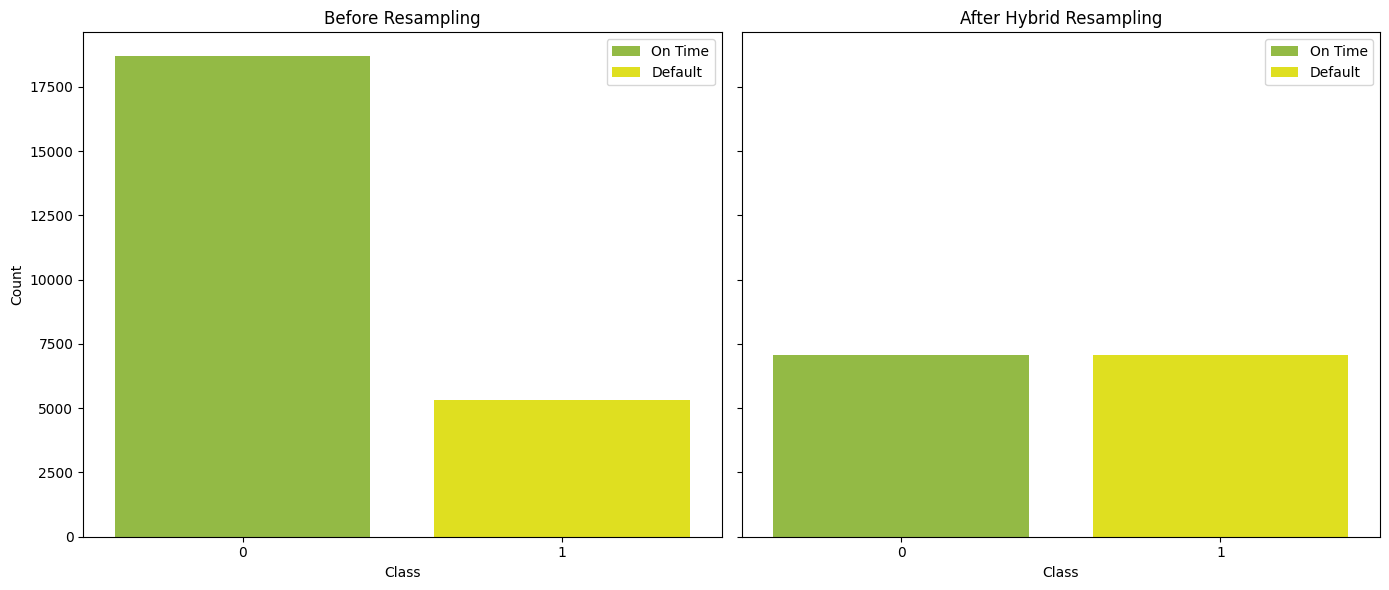

Hybrid Resampling: Precision = 0.4590, Recall = 0.5870, F1 Score = 0.5152, ROC-AUC = 0.7587


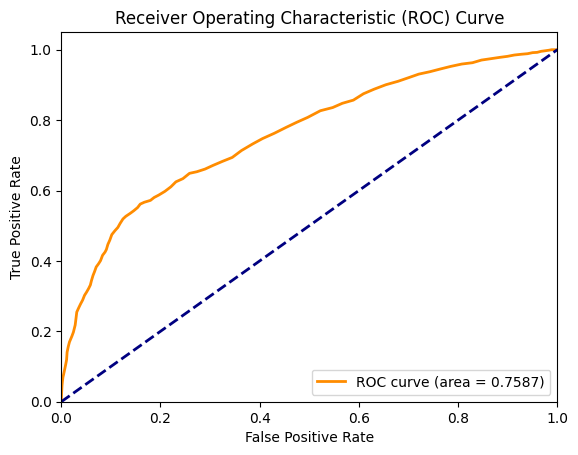

In [ ]:
# Import necessary libraries
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to extract metrics from the classification report
def extract_metrics(report):
    """Extract precision, recall, and f1-score for class '1' from the classification report."""
    if '1' in report:
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
    else:
        precision = recall = f1 = 0
    return precision, recall, f1

# Function to plot class distribution
def plot_class_distribution(y_before, y_after, title_before="Before Resampling", title_after="After Resampling"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    custom_colors = ['yellowgreen', 'yellow']

    # Plot before resampling
    sns.countplot(x=y_before, hue=y_before, palette=custom_colors, ax=axes[0], legend=False)
    axes[0].set_title(title_before)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].legend(['On Time', 'Default'])

    # Plot after resampling
    sns.countplot(x=y_after, hue=y_after, palette=custom_colors, ax=axes[1], legend=False)
    axes[1].set_title(title_after)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')
    axes[1].legend(['On Time', 'Default'])

    plt.tight_layout()
    plt.show()

# Apply RandomUnderSampler with the chosen ratio
undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_processed, y_train)

# Apply SMOTE to the undersampled data
smote = SMOTE(random_state=42)
X_train_hybrid, y_train_hybrid = smote.fit_resample(X_train_under, y_train_under)

# Plot class distribution before and after hybrid resampling
plot_class_distribution(y_train, y_train_hybrid, title_before="Before Resampling", title_after="After Hybrid Resampling")

# Convert to PyTorch tensors
X_train_tensor_hybrid = torch.tensor(X_train_hybrid, dtype=torch.float32)
y_train_tensor_hybrid = torch.tensor(y_train_hybrid.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define a basic random forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the hybrid resampled data
rf_model.fit(X_train_hybrid, y_train_hybrid)

# Predict on the test set
test_predictions = rf_model.predict(X_test_processed)
test_probabilities = rf_model.predict_proba(X_test_processed)[:, 1]

# Evaluate the model
report = classification_report(y_test, test_predictions, output_dict=True)
precision, recall, f1 = extract_metrics(report)
roc_auc = roc_auc_score(y_test, test_probabilities)

# Print the final metrics
print(f"Hybrid Resampling: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Metrics for the undersampling approach with ratio 0.75
undersampling_metrics = {
    'precision': 0.4934,
    'recall': 0.5614,
    'f1_score': 0.5252,
    'roc_auc': 0.7615
}

# Metrics for the hybrid resampling approach
hybrid_metrics = {
    'precision': precision,  # Extracted from the hybrid resampling model evaluation
    'recall': recall,        # Extracted from the hybrid resampling model evaluation
    'f1_score': f1,          # Extracted from the hybrid resampling model evaluation
    'roc_auc': roc_auc       # Extracted from the hybrid resampling model evaluation
}

# Print and compare the metrics
print("Undersampling with Ratio 0.75:")
for metric, value in undersampling_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nHybrid Resampling:")
for metric, value in hybrid_metrics.items():
    print(f"{metric}: {value:.4f}")


Undersampling with Ratio 0.75:
precision: 0.4934
recall: 0.5614
f1_score: 0.5252
roc_auc: 0.7615

Hybrid Resampling:
precision: 0.4590
recall: 0.5870
f1_score: 0.5152
roc_auc: 0.7587


### Analyzing the Results

1. **Precision**:
   - The precision for the hybrid approach (0.4590) is lower than that of undersampling with ratio 0.75 (0.4934). This means the hybrid model has a higher rate of false positives.

2. **Recall**:
   - The recall for the hybrid approach (0.5870) is higher than that of undersampling with ratio 0.75 (0.5614). This means the hybrid model is better at identifying true positives.

3. **F1 Score**:
   - The F1 score for the hybrid approach (0.5152) is slightly lower than that of undersampling with ratio 0.75 (0.5252). This indicates that the hybrid model does not provide a better balance between precision and recall compared to the undersampling method.

4. **ROC-AUC**:
   - The ROC-AUC for the hybrid approach (0.7587) is slightly lower than that of undersampling with ratio 0.75 (0.7615). This suggests a marginal decrease in the model's overall ability to distinguish between classes.

### Conclusion

Based on the comparison:

- **Undersampling with Ratio 0.75** provides a better balance of precision, recall, and F1 score, along with a slightly higher ROC-AUC.
- **Hybrid Resampling** improves recall but at the cost of precision and F1 score, and does not significantly improve ROC-AUC.

### Recommendation

Stick with the **Undersampling with Ratio 0.75** approach as it provides the best overall performance based on the key metrics.



## Incorporate Undersampling



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the data
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

optimal_threshold = 0.8000141978263855

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the sklearn wrapper for the neural network model
class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight  # Accept as float
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        # Convert pos_weight to tensor here
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > optimal_threshold).float()  # Use the manually adjusted threshold here
        return predictions.numpy().squeeze()

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnSimpleNN with the adjusted weight
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(), test_predictions))


              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      4673
         1.0       0.57      0.48      0.52      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.69      0.70      6000
weighted avg       0.79      0.80      0.80      6000

